# Praktikum 0
## Mathematical modeling of the atmosphere


### Integrating simple closure equations for moisture

Consider the following set of 1D equations for moisture variables. The domain is $z=[0,1]$
First, the grid-mean total water mixing ratio, $\overline{r_t}(t,z)$, depends on the vertical flux of $r_t$, $\overline{w'r'_t}(t,z)$:

$$\frac{\delta \overline{r_t}}{\delta t} = -\frac{\delta}{\delta z}\overline{w'r'_t}$$
Second, the flux $\overline{w'r'_t}$ is assumed to be related to $\overline{r_t}$ by

$$\overline{w'r'_t}=-K\frac{\delta\overline{r_t}}{\delta z}$$

That is, the flux is determined by down-gradient diffusion. The boundary condition at the
boundaries $z=[0,1]$ is $\overline{w'r'_t}=0$.
Finally, the sub-grid variance of total water, $\overline{{r'_t}^2}(t,z)$, is assumed to be adequately diagnosed by the algebraic expression

$$\overline{{r'_t}^2}=\tau K (\frac{\delta \overline{r_t}}{\delta z})^2$$

where $\tau=1$ is a prescribed eddy turnover time, and $K=K(z)$ is a prescribed eddy diffusivity:

$$K(z) = \begin{cases} 1, & \text{   if $z<=1/2$} \\ z + 1/2, & \text{  $1/2<z<=1$}\end{cases}$$
The initial profile of total water diminishes with height above the mixed layer:

$$\overline{r_t}(t=0,z) = \begin{cases} r_{t,sfc}, & \text{   if $z<=1/2$} \\ -r_{t,sfc}(z-1/2) + r_{t,sfc}, & \text{  $1/2<z<=1$} \end{cases}$$

where $r_{t,sfc}=10$.

In [100]:
"""Assuming t_t0(z) for z outside the boarders equals 1."""

rt_srf = 10


def r_t0(z):
    if z > 1:
        return 1
    elif z > 0.5:
        return -rt_srf * (z - 0.5) + rt_srf
    else:
        return rt_srf

In [101]:
"""Assuming k(z) for z outside the boarders equals 1."""


def k(z):
    if z > 1:
        return 1
    elif z > 0.5:
        return z + 0.5
    else:
        return 1

So equation (1) in (2) is now:

$$\frac{\delta \overline{r_t}}{\delta t}=\frac{\delta}{\delta z}(K\cdot\frac{\delta \overline{r_t}}{\delta z})$$

We will have a vector $\overline{r_t}$ which represents the searched values.

In [102]:
import numpy as np

n = 100
# Create vector with n values which are equally spaced between 0 and 10.
r_t = np.linspace(0, 1, n)

# Create a height vector with the same dimension, too.
height = np.copy(r_t)

# Set up the initial condition.
for i in range(len(r_t)):
    r_t[i] = r_t0(height[i])

---
### Exercises:

- Integrate the equations forward in time using a discretization method of your choice.
- Plot the profiles of $\overline{r_t}$ and $\overline{{r'_t}^2}$ for later times.
    Can you explain their behavior in physical terms?
    What do you expect the behavior will be as $t\to\infty$?
---

So we are assuming now that:

$$\frac{\delta \overline{r_t}}{\delta t} \approx \frac{\overline{{r_i}^{n+1}} - \overline{r_i^n}}{\Delta t}$$
And:

$$\frac{\delta^2 \overline{r_t}}{\delta z^2} \approx \frac{1}{\Delta z^2}(\overline{{r_{i+1}^n}} - 2\cdot\overline{r_i^n} + \overline{{r_{i-1}^n}})$$

So in conclusion

$$\frac{\delta \overline{r_t}}{\delta t}=\frac{\delta}{\delta z}(K\cdot\frac{\delta \overline{r_t}}{\delta z})$$
### First Exercise:
becomes

$$\frac{\overline{{r_i}^{n+1}} - \overline{r_i^n}}{\Delta t} = \frac{K}{\Delta z^2}(\overline{{r_{i+1}^n}} - 2\cdot\overline{r_i^n} + \overline{{r_{i-1}^n}})$$
$$\Rightarrow \overline{r_i^{n+1}} = \frac{K\cdot\Delta t}{\Delta z^2}(\overline{{r_{i+1}^n}} - 2\cdot\overline{r_i^n} + \overline{{r_{i-1}^n}}) + \overline{r_i^n}$$
With K dependent on z so actually the index values.

$$\Rightarrow \overline{r_i^{n+1}} = \frac{K(i)\cdot\Delta t}{\Delta z^2}(\overline{{r_{i+1}^n}} - 2\cdot\overline{{r_i}^n} + \overline{{r_{i-1}^n}}) + \overline{r_i^n}$$
Equivalent:

$$\Rightarrow \overline{r_i^{n+1}} = (\frac{K(i)\cdot\Delta t}{\Delta z^2}) \cdot \overline{r_{i+1}^n} - (1 - 2\cdot (\frac{K(i)\cdot\Delta t}{\Delta z^2})) \cdot \overline{r_i^n} + (\frac{K(i)\cdot\Delta t}{\Delta z^2}) \cdot \overline{r_{i-1}^n}$$
Normally we would now create a matrix A to solve

$$A \cdot \overline{r_i^n} = \overline{r_i^{n+1}}$$
With $- (1 - 2\cdot (\frac{K(i)\cdot\Delta t}{\Delta z^2}))$ at the diagonal, $(\frac{K(i)\cdot\Delta t}{\Delta z^2})$ under the diagonal and $(\frac{K(i)\cdot\Delta t}{\Delta z^2})$ over the diagonal, and all other entries $0$.
Because $K$ depends on $z$ we unfortunately cannot do the matrix vector multiplication because we cannot get the right index. So I am going to do it with loops, a very slow variant.

In [103]:
def forward_euler(r, z, delta_t, delta_z):
    # Create a new target vector r_t1
    r_t1 = np.zeros(n)

    for index in range(len(r)):
        if index - 1 >= 0 and index + 1 < len(r):
            a = (k(z[index]) * delta_t) / delta_z ** 2
            r_t1[index] = a * (r[index + 1] - 2 * r[index] + r[index - 1]) + r[index]
        r_t1[0] = r_t1[1]
        r_t1[len(r) - 1] = r_t1[len(r) - 2]

    return r_t1

So for forwarding the equation in time I am going to use a matrix which has the $\overline{r_t}$ vectors as rows.
So assume that the matrix looks like this:

$$
\begin{matrix}
    \overline{r_{t=0, z0}^0}    &&  \overline{r_{t=0, z1}^0}    && \overline{r_{t=0, z2}^0}     && ...  \\
    \overline{r_{t=1, z0}^1}    &&  \overline{r_{t=1, z1}^1}    && \overline{r_{t=1, z2}^1}     && ...  \\
    ...                     && ...                     && ...                       && ...  \\
\end{matrix}
$$

In [108]:
# Create this matrix with zeros and the dimension 10xn
r_t_n = np.zeros((10, n))
# Copy the start vector in the first row
r_t_n[0] = np.copy(r_t)
deltaT = 1e-6
steps = 10_000
r_t_i = np.copy(r_t)
for i in range(steps):
    # Do the computation for each step
    r_t_i = np.copy(forward_euler(r_t_i, height, deltaT, 1 / n))
    if i % (steps // 10) == 0:
        if i != 0:
            # Write the computed vector in a row inside the matrix if the step is not 0 and i mod (#steps / 10) == 0
            r_t_n[i // (steps // 10)] = np.copy(r_t_i)

Let us now plot the curves inside a plot.

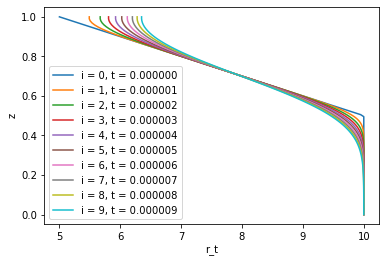

In [109]:
import matplotlib.pyplot as plt

plt.xlabel('r_t')
plt.ylabel('z')
for i in range(10):
    plt.plot(r_t_n[i], height, label=f"i = {i}, t = {(i * deltaT):.6f}")

plt.legend()
plt.show()